# Are there sufficient hospitals in Singapore?

- One of the key amenity for a neighbourhood is a hospital. For a household with elderly or whose family members have chronic conditions, staying near a hospital would translate into less travelling time or even a matter of life or death in a critical situation. So in this task, we look into the hospital coverage for each area in Singapore.

## 1. Configurations

In [1]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import os

import folium
from folium import Marker, GeoJson
from folium.plugins import HeatMap
from shapely.geometry import Point
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

from src.utils import highlight_top, save_fig


In [2]:
sns.set_theme(style="ticks")
sns.set_context("paper", rc={"xtick.labelsize":20,
                             "ytick.labelsize":20,
                             "axes.titlesize":20,
                             "axes.labelsize":20})
default_col = '#4c72b0'
highlight_col = '#c44d52'

In [3]:
# create a folder for plots
os.makedirs("images", exist_ok=True)

In [4]:
img_dir = Path("images")

## 2. Data

- There is no existing hospital data directly available so we will have to scrape our own data. The web scraping script can be found in ``scrape.py``
- The data is obtained healthhub Singapore https://www.healthhub.sg/directory/hospitals
- The coordinates of the hospitals are obtained from the OneMAP RESTAPI https://www.onemap.gov.sg/docs/#onemap-rest-apis

![health-hub](images/healthhub.png)


In [10]:
df_hospital = pd.read_csv("raw_data/additional-data/sg-hospital-data.csv")
df_train_preproc = pd.read_csv("clean_data/train_preproc.csv", index_col=0)

In [11]:
df_hospital.head()

,name,lat,lng
0,ALEXANDRA HOSPITAL,1.28812220833697,103.799444839251
1,ANG MO KIO - THYE HUA KWAN HOSPITAL,1.38403248432085,103.840356912671
2,BRIGHT VISION HOSPITAL,1.37203701009478,103.878031146933
3,CHANGI GENERAL HOSPITAL,1.34131853771386,103.948193352903
4,COMPLEX MEDICAL CENTRE,1.35817565889842,103.973191628726


In [12]:
df_train_preproc.head()

,property_type,built_year,num_beds,num_baths,size_sqft,total_num_units,lat,lng,subzone,planning_area,...,mean_property_sqft,mean_planning_sqft,planning_area_mean,total_rooms,size_per_room,mean_property_type,distance,num_shopping_malls,tenure_99-year leasehold,tenure_freehold
0,hdb,1988,3.0,2.0,1115,116,1.414399,103.837196,yishun south,yishun,...,1079.757868,1231.474343,1.143726e+06,5.0,223.0,6.620452e+05,0.573567,2.0,1,0
1,hdb,1992,4.0,2.0,1575,375,1.372597,103.875625,serangoon north,serangoon,...,1079.757868,2514.468039,3.670975e+06,6.0,262.5,6.620452e+05,1.728895,3.0,1,0
2,condo,2022,4.0,6.0,3070,56,1.298773,103.895798,mountbatten,marine parade,...,1154.798804,2011.903265,4.159877e+06,10.0,307.0,2.919816e+06,1.315256,5.0,0,1
3,condo,2023,3.0,2.0,958,638,1.312364,103.803271,farrer court,bukit timah,...,1154.798804,2468.346271,5.576084e+06,5.0,191.6,2.919816e+06,0.723885,4.0,0,1
4,condo,2026,2.0,1.0,732,351,1.273959,103.843635,anson,downtown core,...,1154.798804,1590.161473,4.853464e+06,3.0,244.0,2.919816e+06,0.370022,16.0,1,0


## 3. Data Preprocessing

OneMAP could not identify the coordinate of CRAWFURD HOSPITAL. We will manually add it in instead.

In [13]:
df_hospital.at[5, "lat"] = 1.32675
df_hospital.at[5, "lng"] = 103.81335

We will remove "INSTITUTE OF MENTAL HEALTH" as it is a more specialized hospital that does not provide the same services a normal hospital would.

In [14]:
df_hospital = df_hospital[df_hospital["name"] != "INSTITUTE OF MENTAL HEALTH / WOODBRIDGE HOSPITAL"].reset_index().drop("index", axis=1)

In [15]:
df_hospital['lat'] = df_hospital['lat'].apply(lambda x: float(x))
df_hospital['lng'] = df_hospital['lng'].apply(lambda x: float(x))

### 3.1 Create geometry point and .SHP file

- .SHP files are shapefile format.
- shapefile stores the geometric location and attribute information of geographic features

In [17]:
df_hospital['geometry'] = [Point(xy) for xy in zip(df_hospital['lng'], df_hospital['lat'])] 

c:\Users\Joanna\anaconda3\envs\cs5228\lib\site-packages\pandas\core\dtypes\cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [18]:
df_train_preproc['geometry'] = [Point(xy) for xy in zip(df_train_preproc['lng'], df_train_preproc['lat'])] 

In [19]:
df_train_preproc_shp = df_train_preproc.loc[:,["lat", "lng", "geometry"]]
df_hospital_shp = df_hospital

In [21]:
df_train_preproc_shp = gpd.GeoDataFrame(df_train_preproc_shp, geometry="geometry")
df_hospital_shp = gpd.GeoDataFrame(df_hospital, geometry="geometry")

In [17]:
# save the shapefile
# df_train_preproc_shp.to_file("SHP/df_train_preproc_shp.shp", driver='ESRI Shapefile')
# df_hospital_shp.to_file("SHP/df_hospital_shp.shp", driver='ESRI Shapefile')

## 4. Identifying areas that are within and outside of radius

In [22]:
# read the shapefile
df_hospital_shp = gpd.read_file("SHP/df_hospital_shp.shp")
df_train_preproc_shp = gpd.read_file("SHP/df_train_preproc_shp.shp")

In [23]:
# Set the coordinate reference system (CRS)
df_hospital_shp = df_hospital_shp.set_crs("EPSG:4326")
df_train_preproc_shp = df_train_preproc_shp.set_crs("EPSG:4326")

- Buffer here refers to the radius. The ``.buffer`` method returns a geometries representing all points within a given distance of each geometric object. Here, we set the buffer to 3km

In [24]:
# set buffer to 3km radius
buffer = df_hospital_shp.to_crs(epsg=3857).buffer(3000).to_crs(epsg=4326)

In [25]:
style1 = {'fillColor': '#FF5733', 'color': '#FF5733'}

In [26]:
m = folium.Map(location=[1.290270, 103.851959], zoom_start=12)
HeatMap(data=df_train_preproc_shp[['lat', 'lng']], radius=10).add_to(m)

m.save("images/map_all_units.html")
m

In [23]:
m = folium.Map(location=[1.290270, 103.851959], zoom_start=12)
HeatMap(data=df_train_preproc_shp[['lat', 'lng']], radius=10).add_to(m)
for idx, row in df_hospital_shp.iterrows():
    Marker([row['lat'], row['lng']], 
           tooltip=row['name'],
           icon=folium.Icon(color='gray')).add_to(m)
    
# Plot each polygon on the map
folium.GeoJson(buffer,
               style_function=lambda x:style1).add_to(m)
m.save("images/hospital_coverage.html")
m

### 4.1 Outside of buffer region

In [27]:
coverage = gpd.GeoDataFrame(geometry=df_hospital_shp.geometry).to_crs(epsg=3857).buffer(3000).to_crs(epsg=4326)
my_union = coverage.geometry.unary_union
outside_range = df_train_preproc_shp.loc[~df_train_preproc_shp["geometry"].apply(lambda x: my_union.contains(x))]

In [28]:
outside_range

,lat,lng,geometry
7,1.342340,103.784489,POINT (103.78449 1.34234)
15,1.381630,103.742102,POINT (103.74210 1.38163)
37,1.344334,103.878690,POINT (103.87869 1.34433)
40,1.387053,103.772288,POINT (103.77229 1.38705)
43,1.376525,103.757380,POINT (103.75738 1.37652)
...,...,...,...
20065,1.446546,103.803916,POINT (103.80392 1.44655)
20072,1.428139,103.772888,POINT (103.77289 1.42814)
20085,1.347253,103.713914,POINT (103.71391 1.34725)
20087,1.319516,103.880974,POINT (103.88097 1.31952)


In [26]:
percentage = round(100*len(outside_range)/len(df_train_preproc_shp), 2)
print("Percentage of listings more than 3 km away from the closest hospital: {}%".format(percentage))

Percentage of listings more than 3 km away from the closest hospital: 15.53%


In [37]:
df_train_preproc["coverage"] = np.where(df_train_preproc_shp.index.isin(outside_range.index), 0, 1)

In [38]:
df_train_preproc.head()

,property_type,built_year,num_beds,num_baths,size_sqft,total_num_units,lat,lng,subzone,planning_area,...,planning_area_mean,total_rooms,size_per_room,mean_property_type,distance,num_shopping_malls,tenure_99-year leasehold,tenure_freehold,geometry,coverage
0,hdb,1988,3.0,2.0,1115,116,1.414399,103.837196,yishun south,yishun,...,1.143726e+06,5.0,223.0,6.620452e+05,0.573567,2.0,1,0,POINT (103.83719568172816 1.41439935),1
1,hdb,1992,4.0,2.0,1575,375,1.372597,103.875625,serangoon north,serangoon,...,3.670975e+06,6.0,262.5,6.620452e+05,1.728895,3.0,1,0,POINT (103.87562460126242 1.3725968000000002),1
2,condo,2022,4.0,6.0,3070,56,1.298773,103.895798,mountbatten,marine parade,...,4.159877e+06,10.0,307.0,2.919816e+06,1.315256,5.0,0,1,POINT (103.895798 1.2987726),1
3,condo,2023,3.0,2.0,958,638,1.312364,103.803271,farrer court,bukit timah,...,5.576084e+06,5.0,191.6,2.919816e+06,0.723885,4.0,0,1,POINT (103.80327091227252 1.3123637),1
4,condo,2026,2.0,1.0,732,351,1.273959,103.843635,anson,downtown core,...,4.853464e+06,3.0,244.0,2.919816e+06,0.370022,16.0,1,0,POINT (103.84363531310518 1.2739587),1


### 4.2 Computing percentage of coverage in each planning area

In [65]:
listings_planning_area = pd.DataFrame(df_train_preproc.groupby("planning_area").size()).reset_index().rename(columns={0:"count"})

In [66]:
coverage_planning_area = pd.DataFrame(df_train_preproc.groupby("planning_area")["coverage"].sum()).reset_index()

In [67]:
percentage_coverage = listings_planning_area.merge(coverage_planning_area, left_on="planning_area", right_on="planning_area", how="inner")

In [74]:
percentage_coverage["percentage"] = round((percentage_coverage["coverage"]/percentage_coverage["count"])*100, 2)
percentage_coverage = percentage_coverage.sort_values(by="percentage", ascending=False)

Saving figure df_no_hosp_planning_area


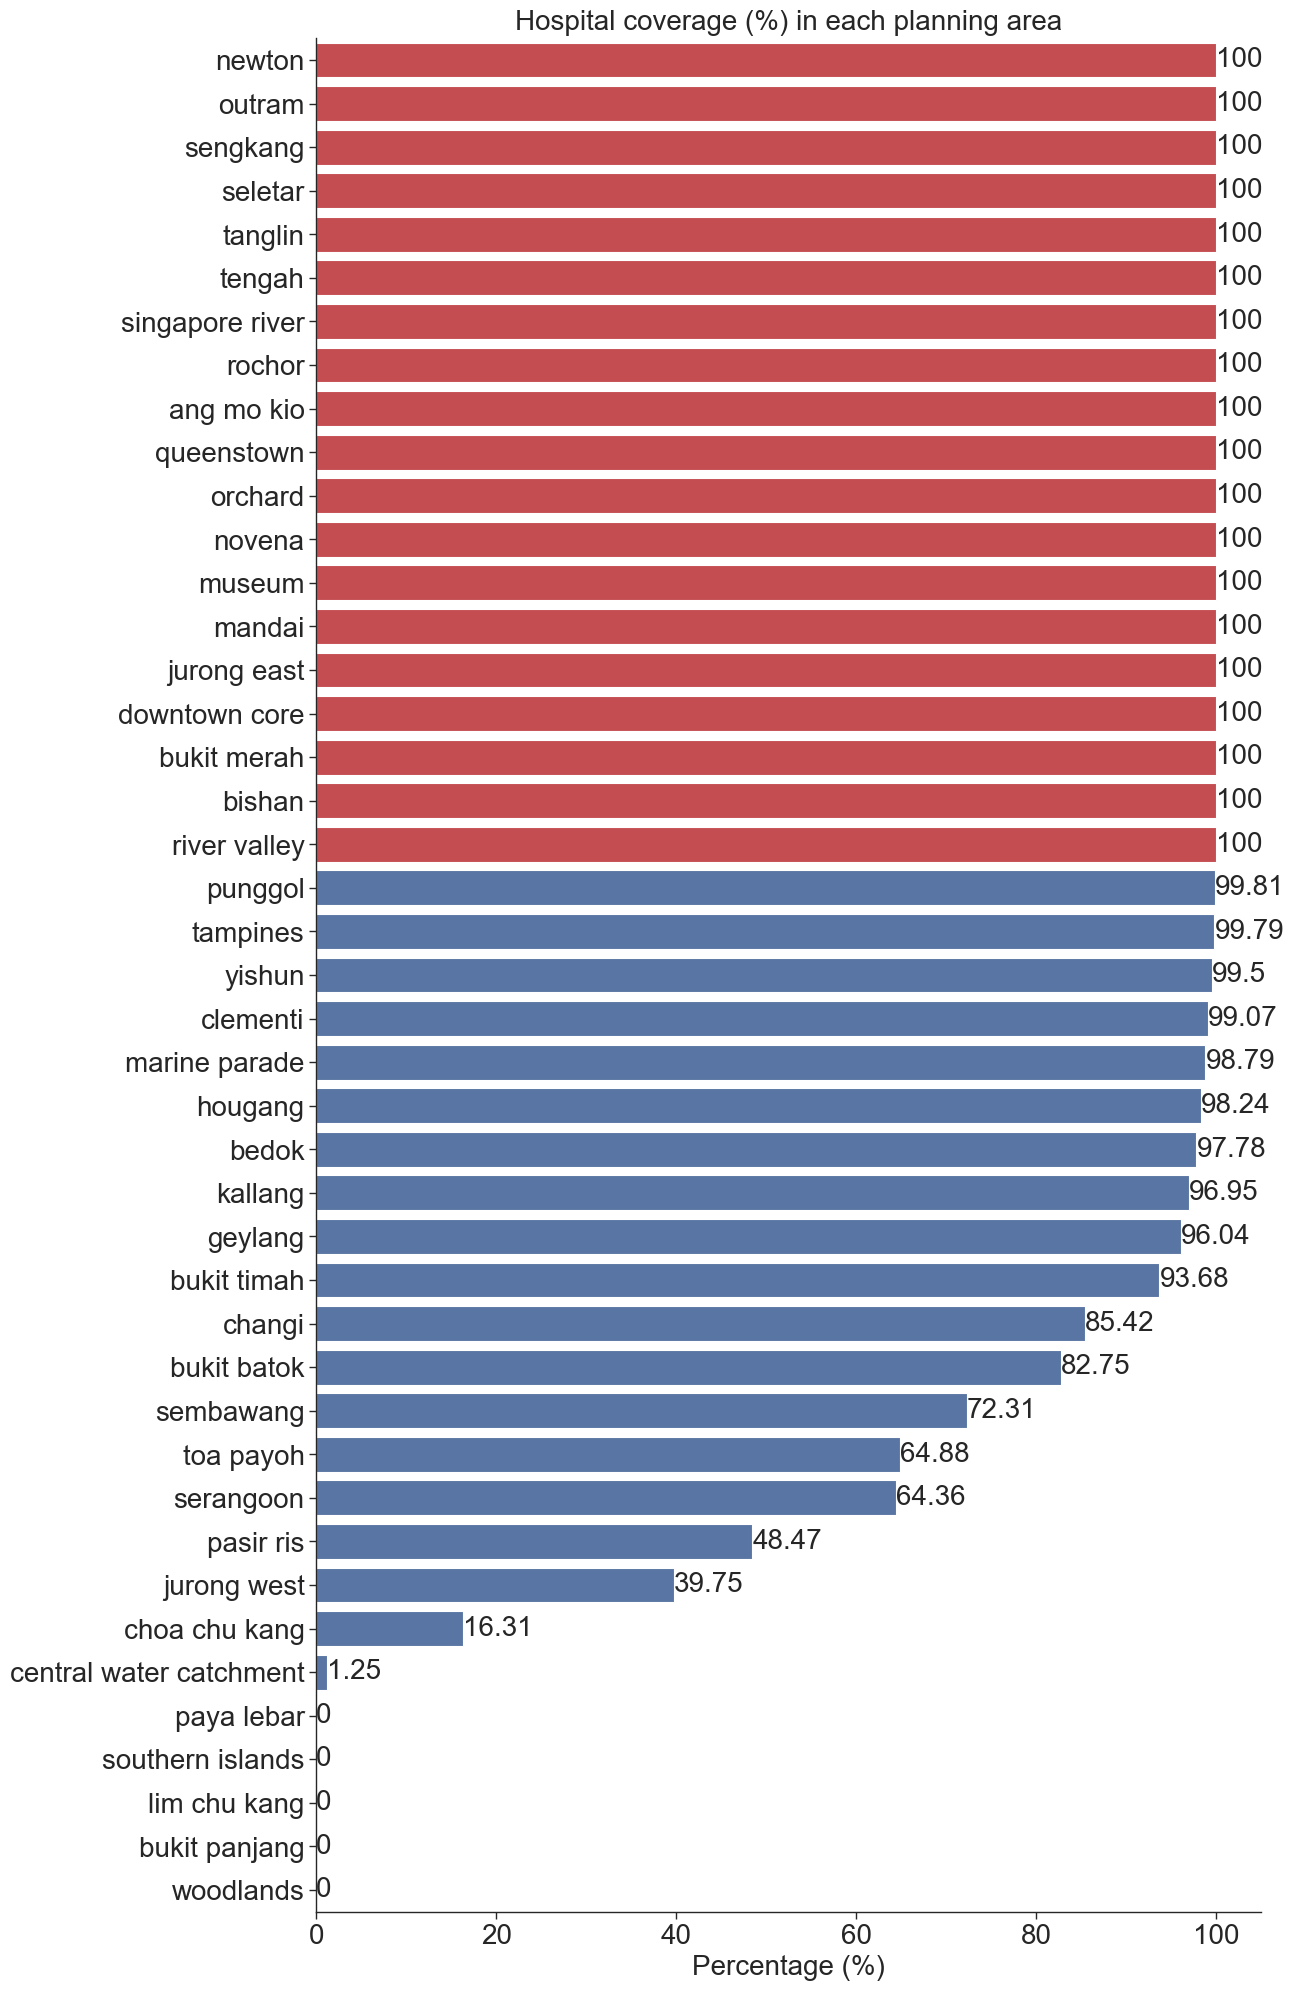

In [81]:
fig, ax = plt.subplots(figsize=(13,20))
ax = sns.barplot(y="planning_area", x="percentage", data=percentage_coverage, color=default_col)
ax.bar_label(ax.containers[0], fontsize=20)
sns.despine()
highlight_top(ax, "horizontal", highlight_col)
plt.title("Hospital coverage (%) in each planning area")
plt.xlabel("Percentage (%)")
plt.ylabel("")
save_fig("df_no_hosp_planning_area", img_dir)
plt.show()